In [ ]:
import os
from PIL import Image
import numpy as np

def load_dataset_from_directory(root_dir, image_size=(32, 32)):
    images = []
    labels = []
    label_names = []

    # Automatically detect subdirectories
    class_folders = sorted(os.listdir(root_dir))

    for label_idx, class_name in enumerate(class_folders):
        class_path = os.path.join(root_dir, class_name)

        if not os.path.isdir(class_path):
            continue

        label_names.append(class_name)  # Save readable label
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, filename)
                img = Image.open(img_path).convert('RGB').resize(image_size)
                img_array = np.array(img)
                images.append(img_array)
                labels.append(label_idx)

    return np.array(images), np.array(labels), label_names


In [ ]:
train_dir = "/content/drive/MyDrive/Transfer learning/Cat and dog/Ball Clascification/train"

data, labels, label_names = load_dataset_from_directory(train_dir)
print("✅ Loaded shape:", data.shape)
print("📌 Label names:", label_names)


✅ Loaded shape: (7330, 32, 32, 3)
📌 Label names: ['american_football', 'baseball', 'basketball', 'billiard_ball', 'bowling_ball', 'cricket_ball', 'football', 'golf_ball', 'hockey_ball', 'hockey_puck', 'rugby_ball', 'shuttlecock', 'table_tennis_ball', 'tennis_ball', 'volleyball']


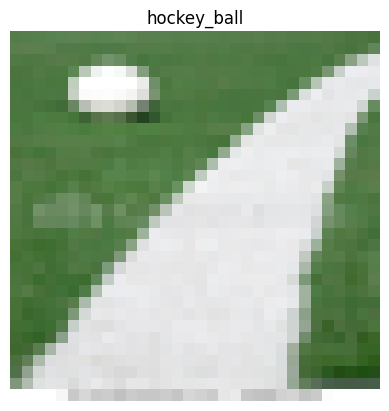

In [ ]:
import matplotlib.pyplot as plt

img = data[4000]
plt.imshow(img)
plt.title(label_names[labels[4000]])
plt.axis('off')
plt.show()


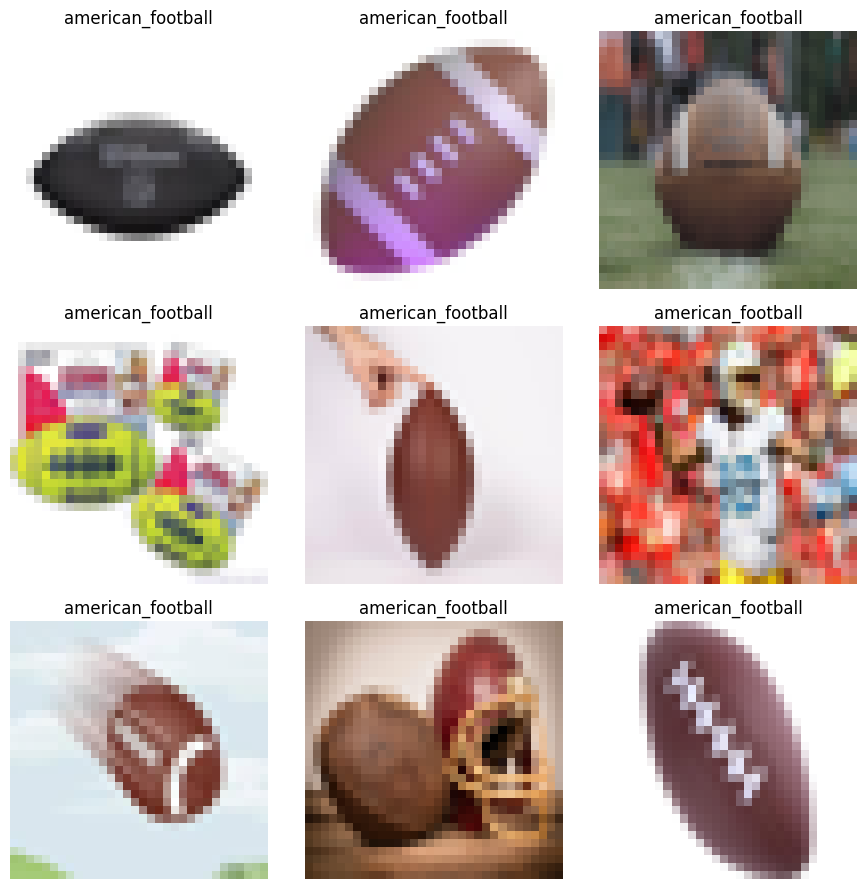

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))  # 3x3 grid, adjust the size as needed

for i, ax in enumerate(axes.flat):  # Flattening the axes array for easy iteration
    if i < 9:  # Ensure there are at least 9 images
        img = data[i]
        ax.imshow(img)
        ax.set_title(label_names[labels[i]])
        ax.axis('off')
    else:
        ax.axis('off')  # Turn off axes for any extra subplots

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]  # Shape: (32, 32, 3)
        img = Image.fromarray(img)  # Convert to PIL Image

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]


In [ ]:
import torch
from torch.utils.data import DataLoader
import timm
import torch.nn as nn
from torchvision import transforms
import tqdm
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model setup
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, len(label_names))  #  output classes  classification
model = model.to(device)  # Move model to device

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
# Transformation to resize images to 224x224
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to (224, 224)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])


In [ ]:
# Define your custom dataset here (as discussed before)
dataset =CustomDataset(data=data, labels=labels, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)

epochs = 5  # You can increase this for better accuracy

In [ ]:

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    print(f"🔁 Starting epoch {epoch + 1}/{epochs}")

    progress_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch + 1}", total=len(train_loader))

    for batch_idx, (images, targets) in enumerate(progress_bar):
        try:
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            progress_bar.set_postfix(loss=loss.item())

        except Exception as e:
            print(f"❌ Error in batch {batch_idx}: {e}")
            continue

    avg_loss = running_loss / len(train_loader)
    print(f"✅ Epoch [{epoch + 1}/{epochs}] Avg Loss: {avg_loss:.4f}")


🔁 Starting epoch 1/5


Epoch 1:   1%|▏         | 3/230 [03:29<4:22:16, 69.32s/it, loss=0.0507]

In [ ]:
model_path = "/content/drive/MyDrive/machin/vit_ball_calssifiction1.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved to {model_path}")

In [ ]:
model_path = "/content/drive/MyDrive/machin/vit_ball_calssifiction.pth"

In [ ]:
test_dir = "/content/drive/MyDrive/Transfer learning/Cat and dog/Ball Clascification/test"
test_data, test_labels, _ = load_dataset_from_directory(test_dir)


In [ ]:
# Use same transform as train (resize to 224, normalize, etc.)
test_dataset = CustomDataset(test_data, test_labels, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Accuracy Evaluation
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

# Compute accuracy
test_acc = evaluate(model, test_loader)
print(f"🧪 Test Accuracy: {test_acc * 100:.2f}%")


🧪 Test Accuracy: 87.83%


In [ ]:
def predict_image(model, image_path, transform, label_names=['american_football', 'baseball', 'basketball', 'billiard_ball', 'bowling_ball', 'cricket_ball', 'football', 'golf_ball', 'hockey_ball', 'hockey_puck', 'rugby_ball', 'shuttlecock', 'table_tennis_ball', 'tennis_ball', 'volleyball']
):
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        output = model(img)
        pred_class = torch.argmax(output, dim=1).item()

    return label_names[pred_class]


In [ ]:
image_path = "/content/drive/MyDrive/Transfer learning/Cat and dog/Ball Clascification/test/american_football/american_football_114.jpg"  # Change this path
predicted_label = predict_image(model, image_path, transform)
print(f"🔍 Predicted label: {predicted_label}")


🔍 Predicted label: american_football


In [ ]:
import torch.nn.functional as F

def show_topk_predictions(image_path, model, transform, label_names=['american_football', 'baseball', 'basketball', 'billiard_ball', 'bowling_ball', 'cricket_ball', 'football', 'golf_ball', 'hockey_ball', 'hockey_puck', 'rugby_ball', 'shuttlecock', 'table_tennis_ball', 'tennis_ball', 'volleyball']
, topk=3):
    # Load and transform image
    img_pil = Image.open(image_path).convert("RGB")
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)
        top_probs, top_idxs = torch.topk(probs, k=topk)

    # Convert to CPU for display
    top_probs = top_probs[0].cpu().numpy()
    top_idxs = top_idxs[0].cpu().numpy()

    # Build prediction strings
    predictions = [
        f"{label_names[idx]}: {prob * 100:.2f}%" for idx, prob in zip(top_idxs, top_probs)
    ]
    prediction_text = "\n".join(predictions)

    # Show image with predictions
    plt.imshow(img_pil)
    plt.title(f"Top-{topk} Predictions:\n{prediction_text}", fontsize=12)
    plt.axis('off')
    plt.show()


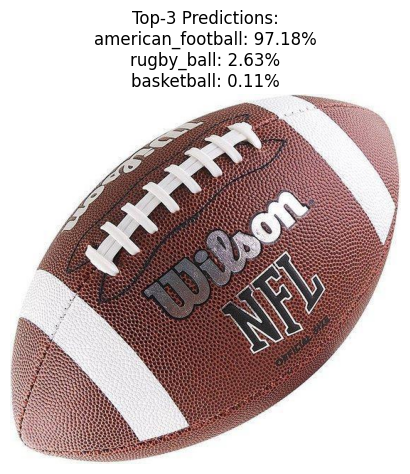

In [ ]:
image_path = "/content/drive/MyDrive/Transfer learning/Cat and dog/Ball Clascification/test/american_football/american_football_114.jpg"  # Change this path
show_topk_predictions(image_path, model, transform)


Enter the image path to predict: /content/drive/MyDrive/Transfer learning/Cat and dog/Ball Clascification/test/cricket_ball/cricket_ball_1012.jpg


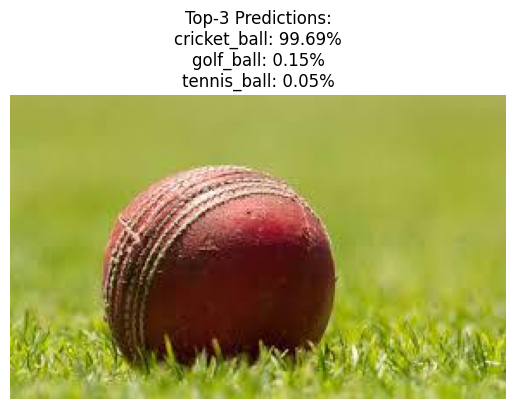

In [ ]:
image_path = str(input("Enter the image path to predict: "))
show_topk_predictions(image_path, model, transform)
